# CONFIG

In [209]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import numpy as np

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid, StratifiedKFold

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
import pickle
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
import shap
import matplotlib.pyplot as plt

import os
import pickle
import shap
import matplotlib.pyplot as plt
import pandas as pd
import json
import random
import numpy as np
from xgboost import DMatrix

In [211]:
import random

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [212]:
DEFAULT_PATH = 'default_path'
DATA_PATH = DEFAULT_PATH + 'data_path'

In [213]:
data = pd.read_csv(DATA_PATH)

# PP

In [214]:
'''  data load  '''

data.drop(columns = ['customerID', 'gender', 'PhoneService'],inplace = True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [215]:
'''  data labeling  '''

columns_to_label = [
    'Partner', 'Dependents', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'PaperlessBilling', 'Churn'
]

# 'Yes' -> 1, 'No' and other similar values -> 0
data[columns_to_label] = data[columns_to_label].replace({
    'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0
})

# change 'Contract' column to months
data['Contract'] = data['Contract'].replace({
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 24
})

# label 'PaymentMethod' column in order of inconvenience # Credit=0, Bank=1, Mailed=2, Electronic=3
data['PaymentMethod'] = data['PaymentMethod'].replace({
    'Electronic check': 3,
    'Mailed check': 2,
    'Bank transfer (automatic)': 1,
    'Credit card (automatic)': 0
})

# label 'InternetService' column in order of expense
data['InternetService'] = data['InternetService'].replace({
    'No': 0,
    'DSL': 1,
    'Fiber optic': 2
})

In [216]:
''' add a service num column '''

services_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                 'StreamingTV', 'StreamingMovies', 'MultipleLines']

data['Services'] = data[services_cols].apply(lambda x: (x == 1).sum(), axis=1)

In [217]:
''' missing value imputation '''

data['TotalCharges'] = data.apply(
    lambda row: row['MonthlyCharges'] * row['tenure'] if pd.isnull(row['TotalCharges']) else row['TotalCharges'],
    axis=1
)

In [218]:
''' column cleanup '''

cols = [col for col in data.columns if col != 'Churn'] + ['Churn']
data = data[cols]

In [219]:
''' method : preparing data set '''

def split_data(data_dict, test_size=0.2, random_state=42):
    train_test_data = {}
    for key, data in data_dict.items():
        train, test = train_test_split(data, test_size=test_size, random_state=random_state)
        train_test_data[f'{key}_train'] = train
        train_test_data[f'{key}_test'] = test
    return train_test_data

# def scale_data(train_data, test_data, columns_to_scale, key): # find
#     scaler = MinMaxScaler()
#     train_data_scaled = train_data.copy()
#     train_data_scaled[columns_to_scale] = scaler.fit_transform(train_data_scaled[columns_to_scale])
#     test_data_scaled = test_data.copy()
#     test_data_scaled[columns_to_scale] = scaler.transform(test_data_scaled[columns_to_scale])

#     with open(f'{key}_scaler.pkl', 'wb') as file:
#         pickle.dump(scaler, file)

#     return train_data_scaled, test_data_scaled

def scale_data_full_dataset(train_data, test_data, columns_to_scale, key): # final
    combined_data = pd.concat([train_data, test_data], axis=0)

    scaler = MinMaxScaler()
    combined_data_scaled = combined_data.copy()
    combined_data_scaled[columns_to_scale] = scaler.fit_transform(combined_data_scaled[columns_to_scale])

    train_data_scaled = combined_data_scaled.iloc[:len(train_data)].reset_index(drop=True)
    test_data_scaled = combined_data_scaled.iloc[len(train_data):].reset_index(drop=True)

    with open(f'{key}_scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)

    return train_data_scaled, test_data_scaled

def apply_smote(train_data, target_column, sampling_strategy=1, random_seed=42):
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]

    over = SMOTE(sampling_strategy=sampling_strategy, random_state=random_seed)
    X_resampled, y_resampled = over.fit_resample(X_train, y_train)

    return pd.DataFrame(X_resampled, columns=X_train.columns), pd.Series(y_resampled)

def process_data_with_smote(data_dict, target_column):
    resampled_results = {}

    for key in data_dict.keys():
        if 'train' in key:
            resampled_X, resampled_y = apply_smote(data_dict[key], target_column)
            resampled_data = resampled_X.copy()
            resampled_data[target_column] = resampled_y
            resampled_results[key] = resampled_data
        if 'test' in key:
            resampled_results[key] = data_dict[key]
    return resampled_results

In [220]:
''' src : preparing data set '''

columns_to_split = ['Partner', 'Dependents']
data_dict = {'data': data}

for partner_val in [0, 1]:
    for dependents_val in [0, 1]:
        filtered_data = data[(data['Partner'] == partner_val) & (data['Dependents'] == dependents_val)].drop(columns=columns_to_split)
        key_name = f'P{partner_val}_D{dependents_val}_data'
        data_dict[key_name] = filtered_data

split_results = split_data(data_dict)

columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract']
scaled_results = {}

for key in split_results.keys():
    if 'train' in key:
        test_key = key.replace('train', 'test')
        scaled_train, scaled_test = scale_data_full_dataset(split_results[key], split_results[test_key], columns_to_scale, key)
        scaled_results[f'{key}_scaled'] = scaled_train
        scaled_results[f'{test_key}_scaled'] = scaled_test

resampled_results = process_data_with_smote(split_results, 'Churn')

for key, df in resampled_results.items():
    print(f"{key}: {df.shape}")

data_train: (8276, 19)
data_test: (1409, 19)
P0_D0_data_train: (3434, 17)
P0_D0_data_test: (656, 17)
P0_D1_data_train: (446, 17)
P0_D1_data_test: (73, 17)
P1_D0_data_train: (1972, 17)
P1_D0_data_test: (331, 17)
P1_D1_data_train: (2388, 17)
P1_D1_data_test: (350, 17)


# XAI

In [221]:
''' method : xai plot '''

def load_model_from_pkl(model_filename):
    FILE_PATH = os.path.join(DEFAULT_PATH, 'model/')
    model_path = os.path.join(FILE_PATH, model_filename)

    with open(model_path, 'rb') as file:
        loaded_obj = pickle.load(file)
        return loaded_obj['model'], loaded_obj['optimal_threshold']

def check_feature_match(model, X_test):
    model_feature_names = model.get_booster().feature_names
    if len(model_feature_names) != X_test.shape[1]:
        raise ValueError(f"Feature mismatch: Model expects {len(model_feature_names)} features but got {X_test.shape[1]} features.")

def calculate_and_plot_shap(model, X_test, model_name):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    plt.figure()
    plt.title(f"SHAP Summary Plot for {model_name}")
    shap.summary_plot(shap_values, X_test, show=False)

    plt.figure()
    shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0], matplotlib=True)
    plt.show()


def shap_analysis_for_models(model_filenames, resampled_results):
    for model_filename in model_filenames:
        model, t = load_model_from_pkl(model_filename)
        model_name = os.path.basename(model_filename)

        prefix = model_name.replace('_model.pkl', '')
        if f"{prefix}_data_train" in resampled_results and f"{prefix}_data_test" in resampled_results:
            X_train = resampled_results[f"{prefix}_data_train"]
            X_test = resampled_results[f"{prefix}_data_test"]
        elif "data_train" in resampled_results and "data_test" in resampled_results:
            X_train = resampled_results["data_train"]
            X_test = resampled_results["data_test"]
        else:
            print(f"No matching data for {model_name}. Skipping...")
            continue

        if prefix in ["P0_D0", "P1_D0", "P0_D1", "P1_D1"]:
            for feature in ["Partner", "Dependent"]:
                if feature in X_train.columns:
                    X_train = X_train.drop(columns=[feature])
                if feature in X_test.columns:
                    X_test = X_test.drop(columns=[feature])

        for feature in ["Churn"]:
            if feature in X_train.columns:
                X_train = X_train.drop(columns=[feature])
            if feature in X_test.columns:
                X_test = X_test.drop(columns=[feature])

        print(f"Analyzing SHAP for {model_name}")
        calculate_and_plot_shap(model, X_test, model_name)

In [222]:
''' method : extract shap_dict '''
def preprocess_input(input_data, mode):
    if mode == "pd":
        input_data = input_data.drop(columns=["Partner", "Dependents", "Churn"])
    elif mode == "all":
        input_data = input_data.drop(columns=["Churn"])
    return input_data

def make_inference(model, X, optimal_threshold):
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    return y_pred, y_pred_proba

def scale_data(data, mode = 'all'):
    COL_TO_SCALE = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract']
    SCALER_PATH = os.path.join(DEFAULT_PATH, 'model/')
    if mode == 'dp' :
        partner_val = data['Partner']
        dependents_val = data['Dependents']
        SCALER_PATH = SCALER_PATH + f'P{partner_val}_D{dependents_val}_'
        data.drop(columns=['Partner', 'Dependents'], inplace=True)

    with open(SCALER_PATH + 'scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    data[COL_TO_SCALE] = scaler.transform(data[COL_TO_SCALE])
    return data

def calculate_and_plot_shap(model, X_test, model_name):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    plt.figure()
    shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0], matplotlib=True)

    return dict(zip(X_test.columns, shap_values[0].values))

def analyze_churn_and_shap(input_data, mode):
    partner_val = input_data["Partner"]
    dependents_val = input_data["Dependents"]

    if mode == "pd":
        model_filename = f'P{partner_val}_D{dependents_val}_model.pkl'
    else:
        model_filename = 'model.pkl'

    model, optimal_threshold = load_model_from_pkl(model_filename)
    model_name = os.path.basename(model_filename)

    processed_input = preprocess_input(scale_data(pd.DataFrame([input_data])), mode)

    churn_prediction, churn_probability = make_inference(model, processed_input, optimal_threshold)
    print(f"Churn Prediction for {model_name}: {churn_prediction}")
    shap_values_dict = calculate_and_plot_shap(model, processed_input, model_name)
    print(f"SHAP values for {model_name}: {shap_values_dict}")

Analyzing SHAP for model.pkl


<Figure size 640x480 with 0 Axes>

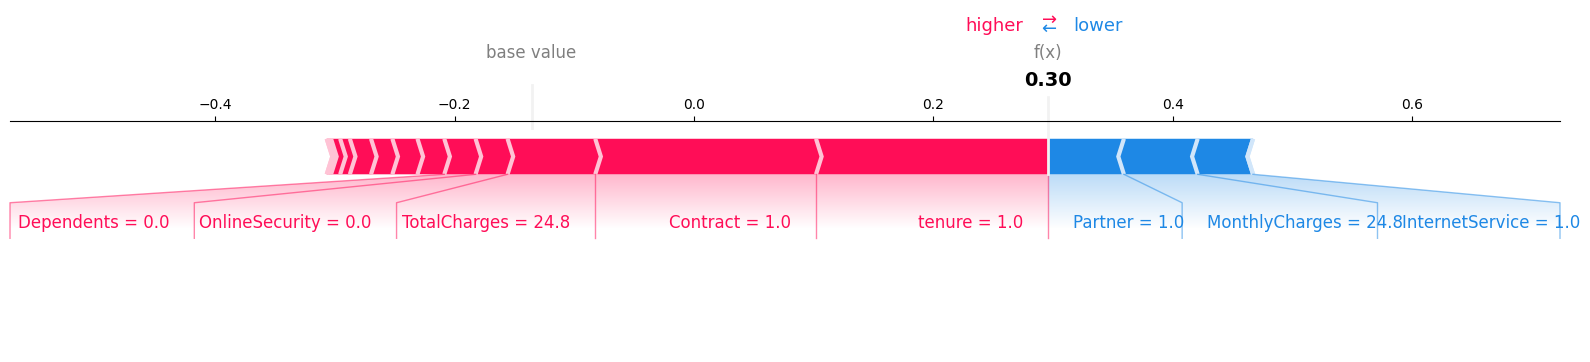

Analyzing SHAP for P0_D0_model.pkl


<Figure size 640x480 with 0 Axes>

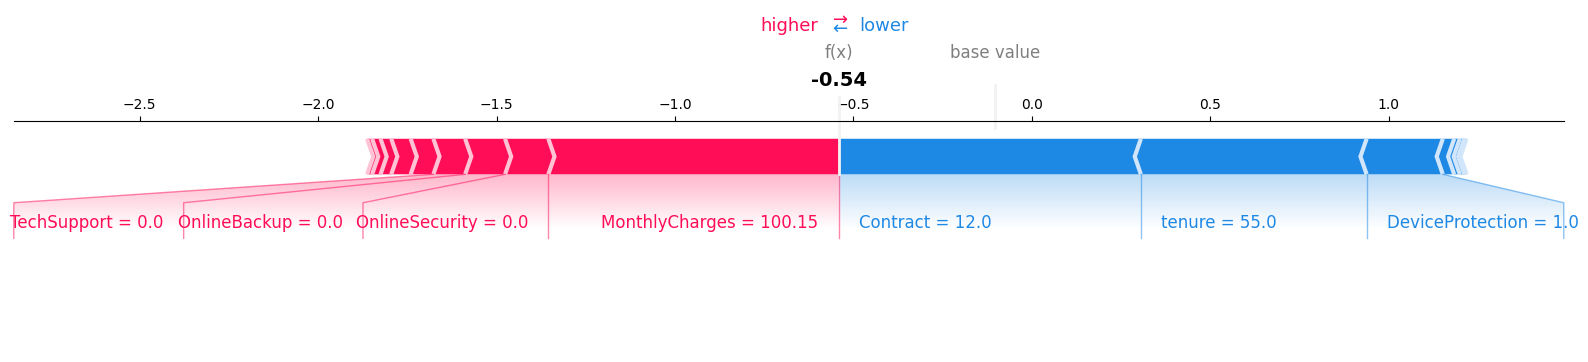

Analyzing SHAP for P1_D0_model.pkl


<Figure size 640x480 with 0 Axes>

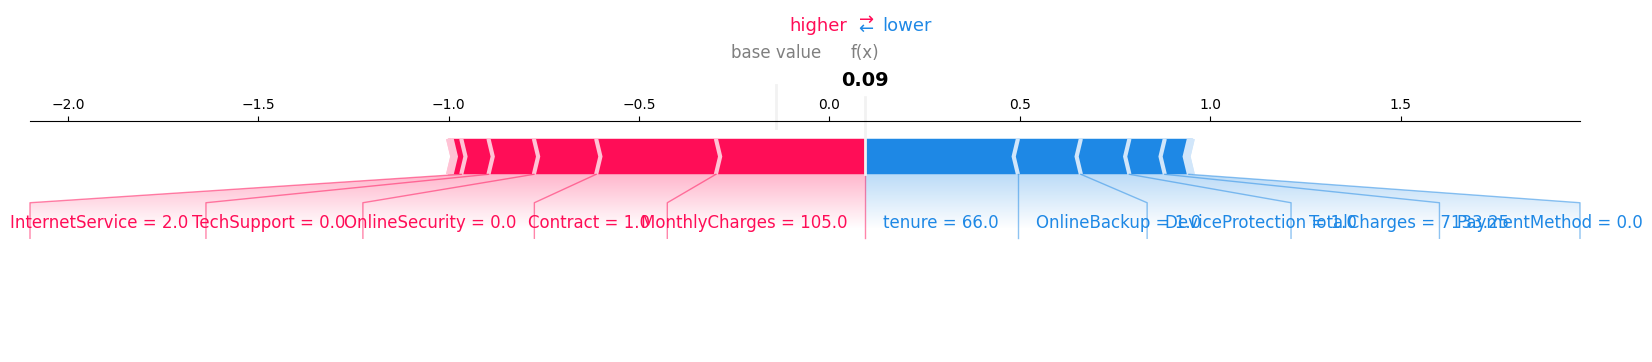

Analyzing SHAP for P0_D1_model.pkl


<Figure size 640x480 with 0 Axes>

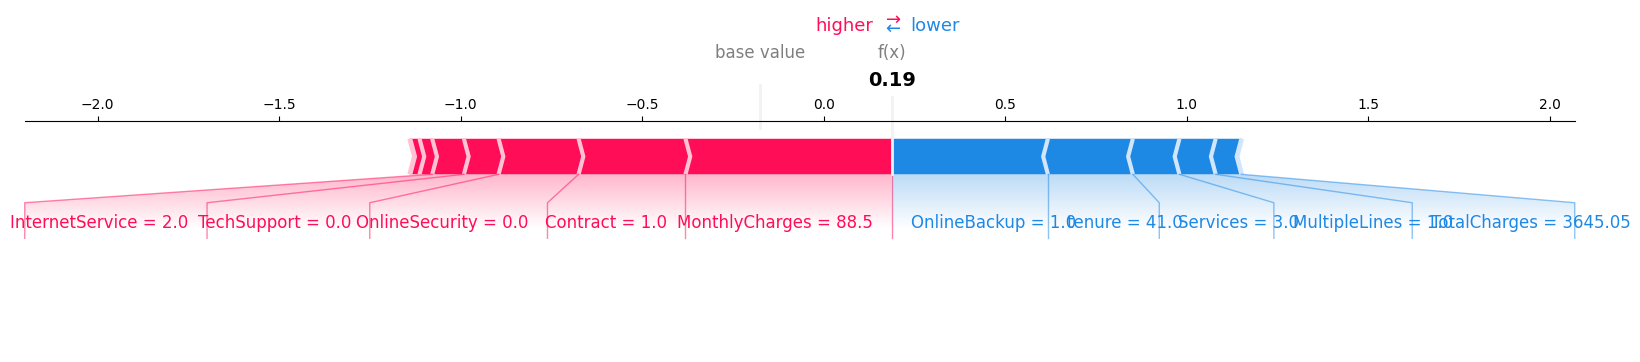

Analyzing SHAP for P1_D1_model.pkl


<Figure size 640x480 with 0 Axes>

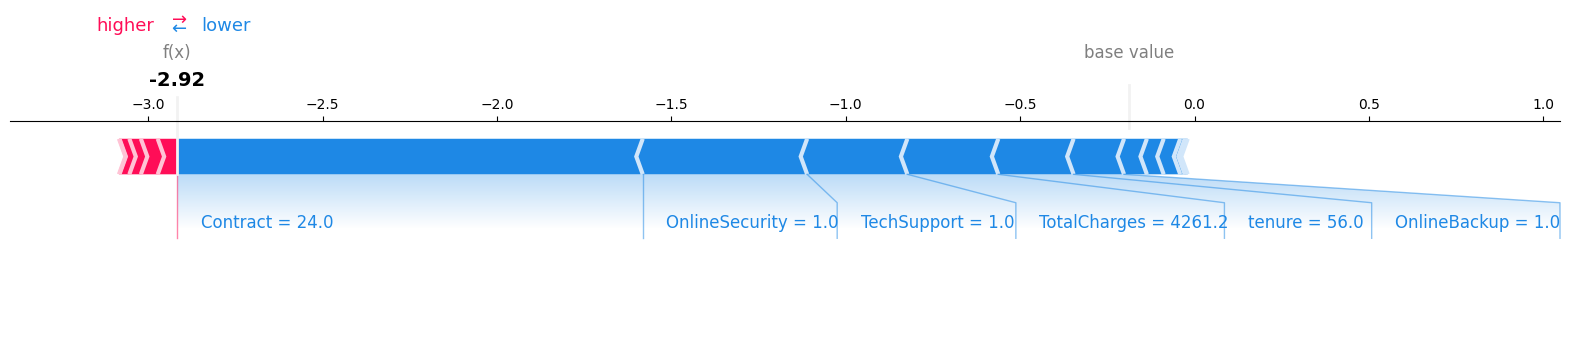

In [223]:
''' src : xai plot '''

model_filenames = ["model.pkl", "P0_D0_model.pkl", "P1_D0_model.pkl", "P0_D1_model.pkl", "P1_D1_model.pkl"]

shap_analysis_for_models(model_filenames, resampled_results)

Churn Prediction for P0_D0_model.pkl: [1]


<Figure size 640x480 with 0 Axes>

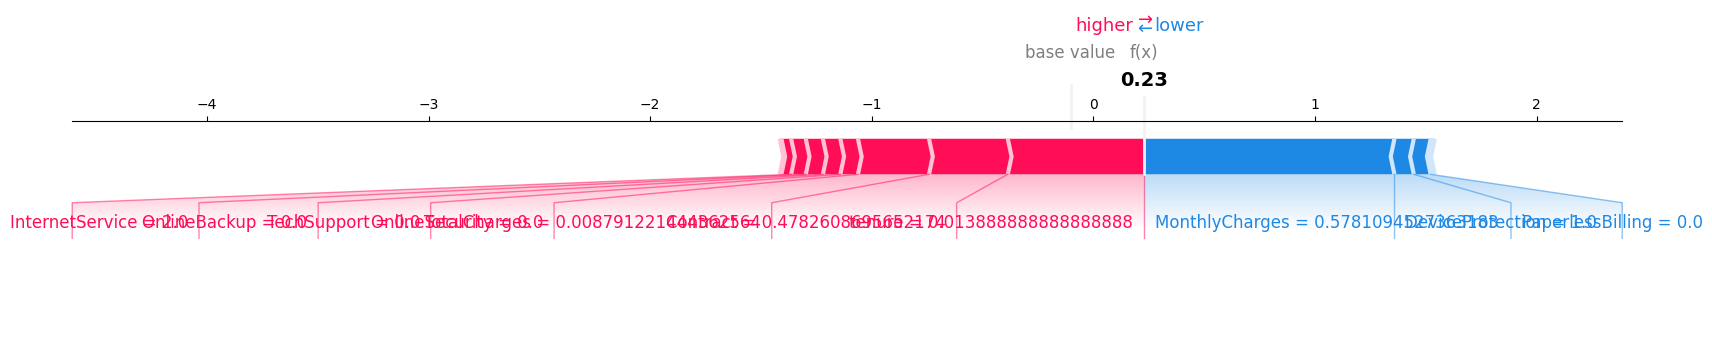

SHAP values for P0_D0_model.pkl: {'SeniorCitizen': -0.0024375254, 'tenure': 0.614207, 'MultipleLines': 0.0042906133, 'InternetService': 0.066016525, 'OnlineSecurity': 0.079519525, 'OnlineBackup': 0.07727236, 'DeviceProtection': -0.087377585, 'TechSupport': 0.07870587, 'StreamingTV': -0.0045181746, 'StreamingMovies': 0.0034765406, 'Contract': 0.35545045, 'PaperlessBilling': -0.07611943, 'PaymentMethod': 0.043850835, 'MonthlyCharges': -1.130405, 'TotalCharges': 0.32074732, 'Services': -0.011405416}


In [224]:
''' src : extract shap_dict '''


input_data = { # example_data
            "SeniorCitizen": 0,
            "Partner": 0,
            "Dependents": 0,
            "tenure": 1,
            "MultipleLines": 0,
            "InternetService": 2,
            "OnlineSecurity": 0,
            "OnlineBackup": 0,
            "DeviceProtection": 1,
            "TechSupport": 0,
            "StreamingTV": 0,
            "StreamingMovies": 0,
            "Contract": 12,
            "PaperlessBilling": 0,
            "PaymentMethod": 3,
            "MonthlyCharges": 76.35,
            "TotalCharges": 76.35,
            "Services": 1,
            "Churn": 1
}

mode = "pd"

analyze_churn_and_shap(input_data, mode)